# **CLICKBAIT DETECTION WITH LSTM**


## My aim in this project is to predict clickbaits other than real news.

Clickbait is a text or a thumbnail link that is designed to attract attention and to entice users to follow that link and read, view, or listen to the linked piece of online content, with a defining characteristic of being deceptive, typically sensationalized or misleading. (Wikipedia)

In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Thu Jun 17 14:24:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **CONNECT GOOGLE DRIVE** 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 Classroom			     modelTraining
 clickbait_data2.csv		    'My Drive'
 clickbait_data.csv		    'Nathan For You - Frozen Yogurt-1.m4v'
'Colab Notebooks'		     trainModel
 Fake.csv			     True.csv
 finalProject_LSTM.ipynb	     Untitled
'https:  drive.m.txt'		     Untitled0.ipynb
'images.zip adlı dosyanın kopyası'   Untitled1.ipynb
 library_management_system.zip	     yolov3
 Model


# **IMPORT REQUIRED LIBRARIES**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# **DATA PREPROCESSING**
I download [clickbait-dataset](https://www.kaggle.com/amananandrai/clickbait-dataset) If clickbait value is 1 text is clickbait if it is 0 non-clickbait.
I download [fake and real news dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) but i use only true news because i dont need fake news.
I download [news clickbait dataset](https://www.kaggle.com/vikassingh1996/news-clickbait-dataset) but I only used train2.csv because train1.csv and clickbait-dataset content same texts.
I want to add fake and real dataset and new clickbait dataset to clickbait dataset. Maybe I can get better results if i use bigger the dataset.

## Lets start read and inspect data.

In [4]:
df = pd.read_csv('gdrive/My Drive/clickbait_data.csv')
df

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [5]:
real_news_df = pd.read_csv('gdrive/My Drive/True.csv')
real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


I dont need text, subject and date columns so i dropped these columns. And i changed title columns because my dataset include only clickbaits and headline. 

In [6]:
real_news_df = real_news_df.drop(['text', 'subject', 'date'], axis=1).rename(columns={'title': 'headline'})
real_news_df['clickbait'] = 0
real_news_df.head()

,headline,clickbait
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


clickbait dataset include news and clickbait in label columns but i need value = 1 for clickbait and value = 0 for non clickbait. So i have to change.

In [8]:
df2 = pd.read_csv('gdrive/My Drive/clickbait_data2.csv')
df2.head()

,label,title
0,news,China and Economic Reform: Xi Jinping’s Track ...
1,news,Trade to Be a Big Topic in Theresa May’s U.S. ...
2,clickbait,"The Top Beaches In The World, According To Nat..."
3,clickbait,Sheriff’s Report Provides New Details on Tamir...
4,news,Surgeon claiming he will transplant volunteer'...


I changed label columns and name of title columns.

In [9]:
df2.label = df2.label.apply(lambda x: 1 if x == "clickbait" else 0)
df2 = df2.rename(columns={'label': 'clickbait', 'title': 'headline'})
df2.head()

,clickbait,headline
0,0,China and Economic Reform: Xi Jinping’s Track ...
1,0,Trade to Be a Big Topic in Theresa May’s U.S. ...
2,1,"The Top Beaches In The World, According To Nat..."
3,1,Sheriff’s Report Provides New Details on Tamir...
4,0,Surgeon claiming he will transplant volunteer'...


Now the datasets look like but columns need to be swapped to be the same.

In [10]:
titles = list(df2.columns)
titles

['clickbait', 'headline']

In [11]:
titles[0],titles[1] = titles[1],titles[0]
titles

['headline', 'clickbait']

In [12]:
df2 = df2[titles]
df2.head()

,headline,clickbait
0,China and Economic Reform: Xi Jinping’s Track ...,0
1,Trade to Be a Big Topic in Theresa May’s U.S. ...,0
2,"The Top Beaches In The World, According To Nat...",1
3,Sheriff’s Report Provides New Details on Tamir...,1
4,Surgeon claiming he will transplant volunteer'...,0


I combine all datasets in df.

In [13]:
df = df.append(real_news_df, ignore_index = True)
df = df.append(df2, ignore_index = True)
df

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
74441,The New Playboy and the End of Adulthood,0
74442,Use of weaponized drones by ISIS spurs terrori...,0
74443,Experts: China might be building database of f...,0
74444,How Trump Can Fix His Troubled White House,0


I dropped all same data.

In [14]:
df.drop_duplicates(keep=False, inplace=False)
df

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
74441,The New Playboy and the End of Adulthood,0
74442,Use of weaponized drones by ISIS spurs terrori...,0
74443,Experts: China might be building database of f...,0
74444,How Trump Can Fix His Troubled White House,0


# **DATA ANALYZING**

I added another column with human readable values such as 'clickbait' or 'real' as our categorical features.

In [15]:
df['category'] = df['clickbait']
df['category'] = df['category'].map({1: 'Clickbait', 0: 'Real_News'})

In [16]:
counts = df.clickbait.value_counts()
print('''
Number of Clickbait headlines in data: {}
Number of real Headlines in data: {}
'''.format(
    counts[1],
    counts[0]))

fig = go.Figure(data=[go.Pie(labels=['Real_News','Clickbait'], values=counts, hole=.3)])
fig.show()


Number of Clickbait headlines in data: 20290
Number of real Headlines in data: 54156



I split dataset into train and test.

In [17]:
text = df['headline'].values
labels = df['clickbait'].values
text_train, text_test, y_train, y_test = train_test_split(text, labels, test_size=0.2)
vocab_size = 5000
maxlen = 500
embedding_size = 32

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text)

X_train = tokenizer.texts_to_sequences(text_train)
x_test = tokenizer.texts_to_sequences(text_test)

X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# **TRAINING AND BUILDING NETWORK**

I build network using LSTM keras model and compile model.

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 242,563
Trainable params: 242,563
Non-trainable params: 0
_________________________________________________________________


I using callbacks. Because I need to control epoches.

In [19]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_loss', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]


I train model for 20 epochs , in mini-batches of 117 samples and fit model.

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
117/117 [==============================] - 36s 247ms/step - loss: 0.6839 - accuracy: 0.6837 - val_loss: 0.6696 - val_accuracy: 0.7262

Epoch 00001: val_loss improved from -inf to 0.66958, saving model to weights.h5
Epoch 2/20
117/117 [==============================] - 28s 241ms/step - loss: 0.6594 - accuracy: 0.7278 - val_loss: 0.6500 - val_accuracy: 0.7262

Epoch 00002: val_loss did not improve from 0.66958
Epoch 3/20
117/117 [==============================] - 28s 241ms/step - loss: 0.6416 - accuracy: 0.7278 - val_loss: 0.6344 - val_accuracy: 0.7262

Epoch 00003: val_loss did not improve from 0.66958
Epoch 4/20
117/117 [==============================] - 28s 243ms/step - loss: 0.6274 - accuracy: 0.7278 - val_loss: 0.6220 - val_accuracy: 0.7262

Epoch 00004: val_loss did not improve from 0.66958
Epoch 5/20
117/117 [==============================] - 28s 241ms/step - loss: 0.6163 - accuracy: 0.7278 - val_loss: 0.6124 - val_accuracy: 0.7262

Epoch 00005: val_loss did not improve

# **ANALYZING**

I plot the loss and accuracy of the model over the training and validation data during training.

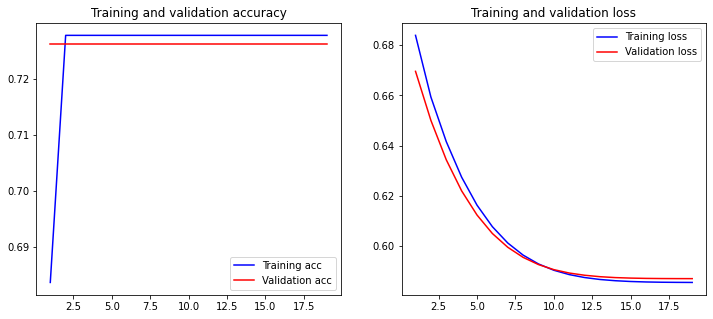

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **BUILDING DIFFERENT NETWORK AND TRAINING MODEL**

The first network didn't produce the results I wanted so I build another network using LSTM.

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________



I train model for 20 epochs , in mini-batches of 50 samples and fit model. 

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
117/117 [==============================] - 15s 109ms/step - loss: 0.5198 - accuracy: 0.7514 - val_loss: 0.2981 - val_accuracy: 0.9136

Epoch 00001: val_loss did not improve from 0.66958
Epoch 2/20
117/117 [==============================] - 12s 99ms/step - loss: 0.2452 - accuracy: 0.9204 - val_loss: 0.2278 - val_accuracy: 0.9226

Epoch 00002: val_loss did not improve from 0.66958
Epoch 3/20
117/117 [==============================] - 12s 100ms/step - loss: 0.2028 - accuracy: 0.9300 - val_loss: 0.2219 - val_accuracy: 0.9218

Epoch 00003: val_loss did not improve from 0.66958
Epoch 4/20
117/117 [==============================] - 12s 99ms/step - loss: 0.1885 - accuracy: 0.9348 - val_loss: 0.2223 - val_accuracy: 0.9220

Epoch 00004: val_loss did not improve from 0.66958
Epoch 5/20
117/117 [==============================] - 12s 99ms/step - loss: 0.1789 - accuracy: 0.9385 - val_loss: 0.2235 - val_accuracy: 0.9198

Epoch 00005: val_loss did not improve from 0.66958
Epoch 6/20
117/117

# **ANALYZING**

I plot the loss and accuracy of the model over the training and validation data during training.

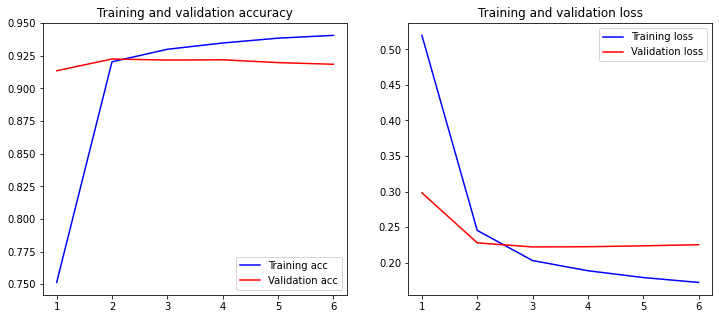

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


# **TESTING**

I test the model with using test set I previously splited.

In [25]:
preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)

In [26]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.82
Precision of the model is 0.87


In [27]:
test = ['My biggest laugh reveal ever!', 'Learning game development with Unity', 'A tour of Japan\'s Kansai region', '12 things NOT to do in Europe']
token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=maxlen)
preds = [round(i[0]) for i in model.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
    print("{} - {}".format(text, label))

My biggest laugh reveal ever! - Clickbait
Learning game development with Unity - Not Clickbait
A tour of Japan's Kansai region - Not Clickbait
12 things NOT to do in Europe - Clickbait
